<a href="https://colab.research.google.com/github/Haakam21/unbump-api/blob/master/model/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

spreadsheets = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
sheet = spreadsheets.open('Pothole Data').sheet1
rows = sheet.get_all_values()
columns = rows.pop(0)

import pandas as pd

features = ['acc_y', 'acc_z', 'acc_dy', 'acc_dz']#, 'spd']
target = 'pothole'

df = pd.DataFrame(rows, columns=columns)
print(df)

          acc_y     acc_z  ...       (acc_z)^2      (acc_dz)^2
0      0.029053  0.013855  ...  0.000191961025  0.000191961025
1      0.030823  0.013916  ...  0.000193655056  0.000000003721
2      0.029846  0.014435  ...  0.000208369225  0.000000269361
3      0.033096  0.006546  ...  0.000042850116  0.000062236321
4      0.028305  0.006882  ...  0.000047361924  0.000000112896
...         ...       ...  ...             ...             ...
11095   0.04216   0.01149  ...    0.0001320201  0.002247613281
11096   0.03302  0.006866  ...  0.000047141956  0.000021381376
11097  0.040878  0.005783  ...  0.000033443089  0.000001172889
11098  0.030701  0.005295  ...  0.000028037025  0.000000238144
11099  0.041931  0.007324  ...  0.000053640976  0.000004116841

[11100 rows x 9 columns]


In [ ]:
data = df[features].astype('float64').to_numpy()
targets = df[target].astype('int64').to_numpy()


window_size = 10
train_split = 8000
batch_size = 256


from tensorflow.keras import preprocessing

train_data_gen = preprocessing.sequence.TimeseriesGenerator(data, targets, window_size, start_index=0, end_index=train_split, shuffle=False, batch_size=batch_size)
val_data_gen = preprocessing.sequence.TimeseriesGenerator(data, targets, window_size, start_index=train_split, end_index=None, shuffle=False, batch_size=batch_size)


In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(window_size, len(features))),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(16),
    layers.Dense(1, activation='sigmoid')
])

import tensorflow.keras.backend as K

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

import tensorflow.keras.metrics as metrics

model.compile(optimizer='adam', loss=f1_loss, metrics=[f1, 'accuracy', metrics.AUC()])

model.summary()

epochs = 50
train = model.fit(train_data_gen, validation_data=val_data_gen, epochs=epochs)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 10, 64)            17664     
_________________________________________________________________
lstm_61 (LSTM)               (None, 10, 32)            12416     
_________________________________________________________________
lstm_62 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 33,233
Trainable params: 33,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 3s 81ms/step - loss: 0.9465 - f1: 0.0592 - accuracy: 0.0606 - auc_8: 0.5864 - val_loss: 0.9531 - val_f1: 0.0454 - val_accuracy: 0.0262 - val_auc_8: 0.4237
Epoch 2/50
32/32 [======================

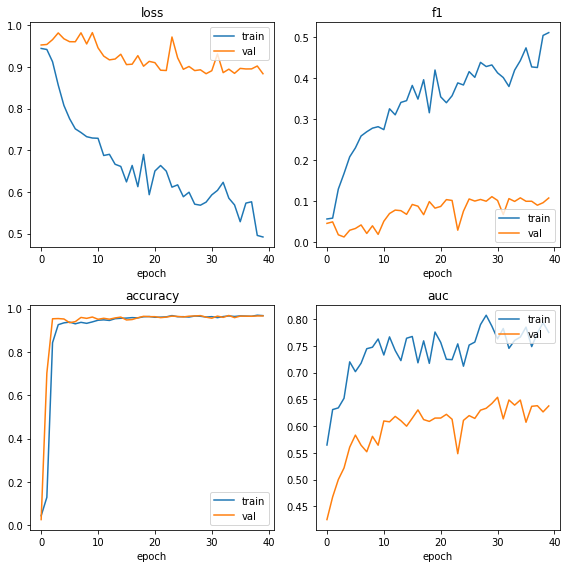

In [ ]:
history = pd.DataFrame(train.history)

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('loss')

plt.subplot(2, 2, 2)
plt.plot(history['f1'], label='train')
plt.plot(history['val_f1'], label='val')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('f1')

plt.subplot(2, 2, 3)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('accuracy')

plt.subplot(2, 2, 4)
plt.plot(history['auc'], label='train')
plt.plot(history['val_auc'], label='val')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('auc')

plt.tight_layout()
plt.show()

In [ ]:
train_data = data[:train_split]
train_targets = targets[:train_split]

val_data = data[train_split:]
val_targets = targets[train_split:]

from imblearn.over_sampling import SMOTE
#NOW TRYING THIS WITH OVERSAMPLING THE DATA
sm = SMOTE(random_state=12, ratio = 1)
SMOTE_data, SMOTE_targets = sm.fit_sample(train_data, train_targets)

train_data_SMOTE = preprocessing.sequence.TimeseriesGenerator(SMOTE_data, SMOTE_targets, window_size, start_index=0, end_index=None, shuffle=False, batch_size=batch_size)
val_data_SMOTE = preprocessing.sequence.TimeseriesGenerator(val_data, val_targets, window_size, start_index=0, end_index=None, shuffle=False, batch_size=batch_size)



countPotholePos = 0
countPotholeNeg = 0
for indexForPotCount in range(len(y_res)):
  if y_res[indexForPotCount] < 0.5:
    countPotholeNeg = countPotholeNeg + 1
  else:
    countPotholePos = countPotholePos + 1
print('number of negative potholes is', countPotholeNeg)
print('number of positive potholes is', countPotholePos)
print('Percentage of potholes data that are have a pothole', (countPotholePos)/(countPotholeNeg + countPotholePos) * 100)

epochs = 50
train = model.fit(train_data_SMOTE, validation_data=val_data_SMOTE, epochs=epochs)

number of negative potholes is 7761
number of positive potholes is 7761
Percentage of potholes data that are have a pothole 50.0
Epoch 1/50
 1/61 [..............................] - ETA: 0s - loss: 2.6941e-05 - f1: 1.0000 - accuracy: 1.0000 - auc_4: 0.0000e+00

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


61/61 [==============================] - 3s 45ms/step - loss: 0.4846 - f1: 0.5186 - accuracy: 0.5041 - auc_4: 0.5051 - val_loss: 0.9511 - val_f1: 0.0454 - val_accuracy: 0.0311 - val_auc_4: 0.5027
Epoch 2/50
61/61 [==============================] - 3s 44ms/step - loss: 0.4846 - f1: 0.5186 - accuracy: 0.5042 - auc_4: 0.5052 - val_loss: 0.9511 - val_f1: 0.0454 - val_accuracy: 0.0311 - val_auc_4: 0.5027
Epoch 3/50
61/61 [==============================] - 3s 44ms/step - loss: 0.4846 - f1: 0.5186 - accuracy: 0.5049 - auc_4: 0.5055 - val_loss: 0.9511 - val_f1: 0.0454 - val_accuracy: 0.0311 - val_auc_4: 0.5028
Epoch 4/50
61/61 [==============================] - 3s 45ms/step - loss: 0.4846 - f1: 0.5186 - accuracy: 0.5050 - auc_4: 0.5057 - val_loss: 0.9511 - val_f1: 0.0454 - val_accuracy: 0.0311 - val_auc_4: 0.5028
Epoch 5/50
61/61 [==============================] - 3s 45ms/step - loss: 0.4846 - f1: 0.5186 - accuracy: 0.5052 - auc_4: 0.5060 - val_loss: 0.9511 - val_f1: 0.0454 - val_accuracy: 0.0

        loss        f1  accuracy  ...    val_f1  val_accuracy  val_auc_4
0   0.484639  0.518606  0.504126  ...  0.045397      0.031068   0.502659
1   0.484637  0.518606  0.504190  ...  0.045397      0.031068   0.502659
2   0.484634  0.518611  0.504899  ...  0.045397      0.031068   0.502825
3   0.484632  0.518611  0.504964  ...  0.045397      0.031068   0.502825
4   0.484631  0.518611  0.505222  ...  0.045397      0.031068   0.502825
5   0.484630  0.518611  0.505415  ...  0.045397      0.031392   0.502825
6   0.484629  0.518611  0.505415  ...  0.045397      0.031392   0.502825
7   0.484628  0.518611  0.505737  ...  0.045397      0.031392   0.502825
8   0.484625  0.518611  0.506189  ...  0.045397      0.031715   0.503323
9   0.484615  0.518625  0.506962  ...  0.045397      0.032039   0.503489
10  0.484601  0.518642  0.507929  ...  0.045423      0.033010   0.504985
11  0.484598  0.518658  0.511797  ...  0.045538      0.034628   0.506148
12  0.484503  0.518748  0.514634  ...  0.044931    

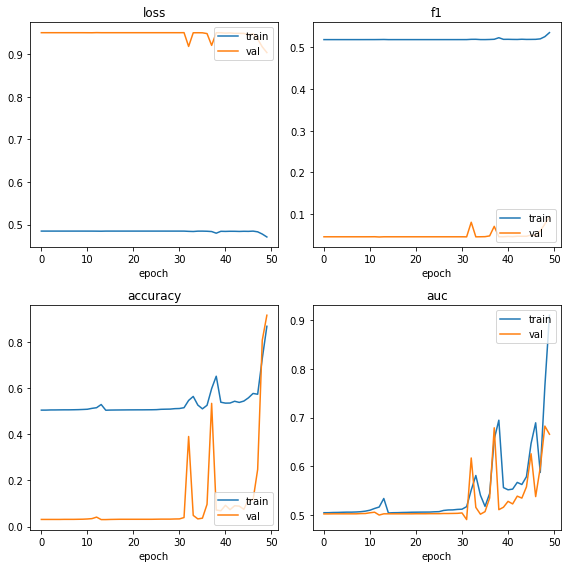

In [ ]:
history = pd.DataFrame(train.history)

print(history)

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('loss')

plt.subplot(2, 2, 2)
plt.plot(history['f1'], label='train')
plt.plot(history['val_f1'], label='val')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('f1')

plt.subplot(2, 2, 3)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title('accuracy')

plt.subplot(2, 2, 4)
plt.plot(history[history.keys()[3]], label='train')
plt.plot(history[history.keys()[7]], label='val')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title('auc')

plt.tight_layout()
plt.show()